In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.tree as tree
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from collections import Counter
import re

# <u>שלב 2</u>

## איחוד הקבצים

In [2]:
# יצירת רשימה לאחסון הקבצים
files = ['booking_hotels_ny2.csv', 'booking_hotels_ny3.csv', 'booking_hotels_ny4.csv']

# יצירת רשימה ריקה לאחסון כל השורות
all_rows = []

# לולאה על כל קובץ ברשימת הקבצים
for file in files:
    # קריאת הקובץ
    df = pd.read_csv(file)
    # הוספת עמודה עם שם הקובץ
    df['source_file'] = os.path.basename(file)
    # ניקוי סימון שח מעמודת מחיר ומחיר לפני הנחה
    df['price'] = df['price'].replace('[₪,]', '', regex=True).astype(int)
    df['price_before_discount'] = df['price_before_discount'].replace('[₪,]', '', regex=True).astype(float)
    # הוספת השורות לרשימה
    all_rows.append(df)

# איחוד כל השורות לטבלה אחת
data = pd.concat(all_rows, ignore_index=True)

# יצירת קובץ CSV חדש עם הנתונים המאוחדים
data.to_csv('merged_booking.csv', index=False)

# Exploration

In [3]:
data.head()

,name,grade,descriptive_grades,num_of_reviews,breakfast,distance_from_center,location_rating,neighborhood,stars,bed_type,...,free_cancellation,no_prepayment,how_many_rooms_left,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,source_file
0,"The Cloud One New York-Downtown, by the Motel ...",8.4,Very good,4667.0,No,NaN,8.9,"Manhattan, New York",4.0,1 extra-large double bed,...,No,No,1,06/07/2024,07/07/2024,1,1,05/07/2024,1,booking_hotels_ny2.csv
1,Margaritaville Resort Times Square,8.7,Fabulous,3243.0,No,1.5,9.2,"Manhattan, New York",4.0,1 large double bed,...,No,No,7,06/07/2024,07/07/2024,1,1,05/07/2024,2,booking_hotels_ny2.csv
2,"33 Hotel, New York City, Seaport",8.7,Fabulous,534.0,No,6.9,9.1,"Manhattan, New York",5.0,1 extra-large double bed,...,No,No,3,06/07/2024,07/07/2024,1,1,05/07/2024,3,booking_hotels_ny2.csv
3,Royalton New York,7.8,Good,2484.0,No,1.4,9.3,"Manhattan, New York",4.0,1 large double bed,...,No,No,No,06/07/2024,07/07/2024,1,1,05/07/2024,4,booking_hotels_ny2.csv
4,NH Collection New York Madison Avenue,8.3,Very good,2028.0,No,NaN,8.8,"Murray Hill, New York",4.0,1 large double bed,...,No,No,7,06/07/2024,07/07/2024,1,1,05/07/2024,5,booking_hotels_ny2.csv


In [4]:
data.sample()

,name,grade,descriptive_grades,num_of_reviews,breakfast,distance_from_center,location_rating,neighborhood,stars,bed_type,...,free_cancellation,no_prepayment,how_many_rooms_left,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,source_file
74464,Wyndham Garden Chinatown,7.5,Good,706.0,Yes,5.8,NaN,"Lower East Side, New York",4.0,1 large double bed,...,Yes,Yes,7,02/08/2024,04/08/2024,26,2,07/07/2024,134,booking_hotels_ny4.csv


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78512 entries, 0 to 78511
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   78512 non-null  object 
 1   grade                  78060 non-null  float64
 2   descriptive_grades     78090 non-null  object 
 3   num_of_reviews         78090 non-null  float64
 4   breakfast              78512 non-null  object 
 5   distance_from_center   63746 non-null  float64
 6   location_rating        43377 non-null  float64
 7   neighborhood           78512 non-null  object 
 8   stars                  77775 non-null  float64
 9   bed_type               77886 non-null  object 
 10  room_type              78505 non-null  object 
 11  price                  78512 non-null  int32  
 12  price_before_discount  16951 non-null  float64
 13  free_cancellation      78512 non-null  object 
 14  no_prepayment          78512 non-null  object 
 15  ho

In [6]:
# טיפול בשדות של הדטה
# הפונקציה להמרת המחרוזת לתאריך
def convert_to_date(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')

# החלת הפונקציה על עמודת 'checkin_date'
data['checkin_date'] = data['checkin_date'].apply(convert_to_date)
data['checkout_date'] = data['checkout_date'].apply(convert_to_date)
data['Snapshot Date'] = data['Snapshot Date'].apply(convert_to_date)

# החלפת ערכים והמרה של "No" ל-NULL
data['how_many_rooms_left'].replace({'No': np.nan}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78512 entries, 0 to 78511
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   78512 non-null  object        
 1   grade                  78060 non-null  float64       
 2   descriptive_grades     78090 non-null  object        
 3   num_of_reviews         78090 non-null  float64       
 4   breakfast              78512 non-null  object        
 5   distance_from_center   63746 non-null  float64       
 6   location_rating        43377 non-null  float64       
 7   neighborhood           78512 non-null  object        
 8   stars                  77775 non-null  float64       
 9   bed_type               77886 non-null  object        
 10  room_type              78505 non-null  object        
 11  price                  78512 non-null  int32         
 12  price_before_discount  16951 non-null  float64       
 13  f

In [7]:
#  NULLבדיקת ערכי 
data.isnull().sum()

name                         0
grade                      452
descriptive_grades         422
num_of_reviews             422
breakfast                    0
distance_from_center     14766
location_rating          35135
neighborhood                 0
stars                      737
bed_type                   626
room_type                    7
price                        0
price_before_discount    61561
free_cancellation            0
no_prepayment                0
how_many_rooms_left      42525
checkin_date                 0
checkout_date                0
TTT                          0
LOS                          0
Snapshot Date                0
order                        0
source_file                  0
dtype: int64

In [8]:
# הסרת עמודות שרובן null
data = data.drop(['price_before_discount', 'location_rating', 'how_many_rooms_left'], axis=1)

In [9]:
# טיפול בשדות עם מעט ערכים חסרים ומילוי ערכי NULL בערך החציוני
data['grade'] = data['grade'].fillna(data['grade'].median())
data['num_of_reviews'] = data['num_of_reviews'].fillna(data['num_of_reviews'].median())
data['distance_from_center'] = data['distance_from_center'].fillna(data['distance_from_center'].median())

# הורשת שדה מיותר שהופנו לבדיקת איחוד הקבצים
data = data.drop(['source_file'], axis=1)

In [10]:
# הסרת null 
data = data[data['stars'].notna()]
data = data[data['bed_type'].notna()]
data = data[data['room_type'].notna()]
data = data[data['descriptive_grades'].notna()]

In [11]:
data.isnull().sum()

name                    0
grade                   0
descriptive_grades      0
num_of_reviews          0
breakfast               0
distance_from_center    0
neighborhood            0
stars                   0
bed_type                0
room_type               0
price                   0
free_cancellation       0
no_prepayment           0
checkin_date            0
checkout_date           0
TTT                     0
LOS                     0
Snapshot Date           0
order                   0
dtype: int64

# גרפים מבוקשים

## גרף מספר ביקורות

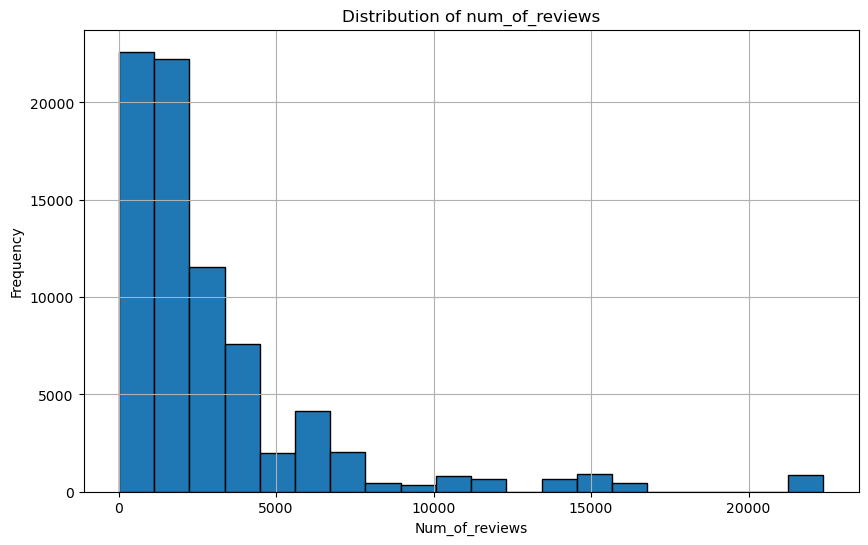

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(data['num_of_reviews'], bins=20, edgecolor='black')
plt.title('Distribution of num_of_reviews')
plt.xlabel('Num_of_reviews')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## גרף ציונים

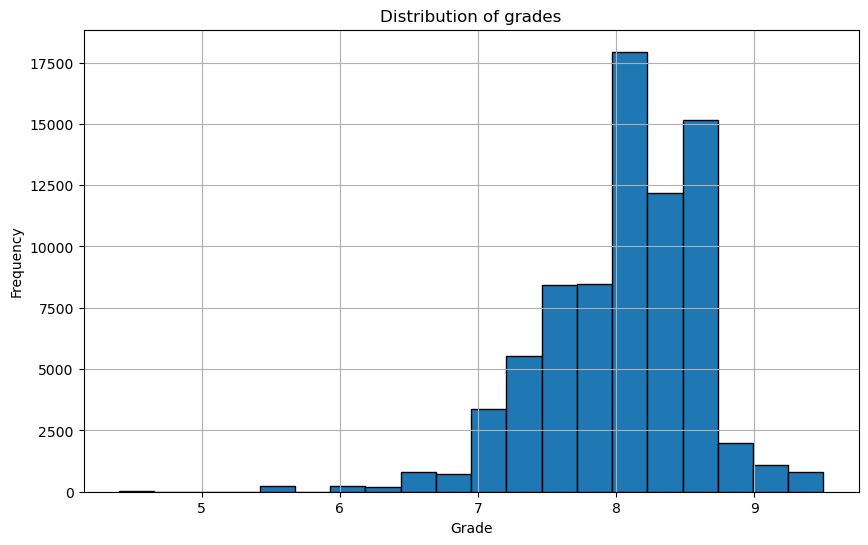

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(data['grade'], bins=20, edgecolor='black')
plt.title('Distribution of grades')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#sns.distplot(data['grade'])

## גרף מחירים

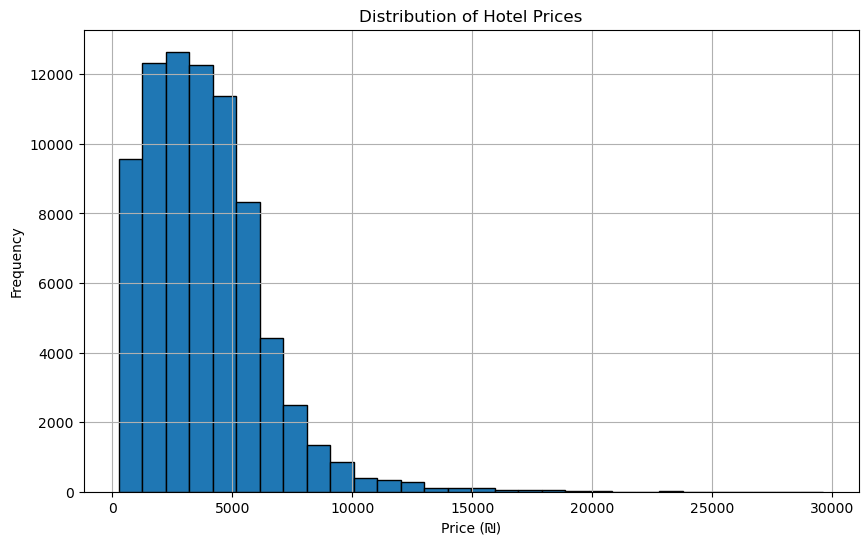

In [14]:
#df['price'] = df['price'].replace('[₪,]', '', regex=True).astype(int)

# Create a histogram of the 'price' column
plt.figure(figsize=(10, 6))
plt.hist(data['price'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Hotel Prices')
plt.xlabel('Price (₪)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## ביצוע outlier על פי שיטת Tukey ( IQR1.5 )


In [15]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Determine the bounds for outliers
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

# Filter the data to remove outliers
data2 = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

# Display the number of removed outliers
num_outliers = data.shape[0] - data2.shape[0]
num_outliers

1787

In [16]:
data=data2
data

,name,grade,descriptive_grades,num_of_reviews,breakfast,distance_from_center,neighborhood,stars,bed_type,room_type,price,free_cancellation,no_prepayment,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order
0,"The Cloud One New York-Downtown, by the Motel ...",8.4,Very good,4667.0,No,1.9,"Manhattan, New York",4.0,1 extra-large double bed,Standard King Room,830,No,No,2024-07-06,2024-07-07,1,1,2024-07-05,1
1,Margaritaville Resort Times Square,8.7,Fabulous,3243.0,No,1.5,"Manhattan, New York",4.0,1 large double bed,Standard Queen Room,1782,No,No,2024-07-06,2024-07-07,1,1,2024-07-05,2
2,"33 Hotel, New York City, Seaport",8.7,Fabulous,534.0,No,6.9,"Manhattan, New York",5.0,1 extra-large double bed,Deluxe Peck Slip King,1556,No,No,2024-07-06,2024-07-07,1,1,2024-07-05,3
3,Royalton New York,7.8,Good,2484.0,No,1.4,"Manhattan, New York",4.0,1 large double bed,Standard Queen Room,1483,No,No,2024-07-06,2024-07-07,1,1,2024-07-05,4
4,NH Collection New York Madison Avenue,8.3,Very good,2028.0,No,1.9,"Murray Hill, New York",4.0,1 large double bed,Superior Room,1727,No,No,2024-07-06,2024-07-07,1,1,2024-07-05,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78507,Four Points by Sheraton Midtown - Times Square,8.1,Very good,2409.0,No,1.6,"Hell's Kitchen, New York",4.0,1 extra-large double bed,King Room,6329,Yes,Yes,2024-08-06,2024-08-11,30,5,2024-07-07,173
78508,ModernHaus SoHo,8.4,Very good,982.0,No,5.4,"SoHo, New York",5.0,1 large double bed,Standard Queen Room,8204,No,No,2024-08-06,2024-08-11,30,5,2024-07-07,174
78509,Aloft New York Chelsea,7.7,Good,63.0,No,2.5,"Chelsea, New York",4.0,1 extra-large double bed,King Room,4926,No,No,2024-08-06,2024-08-11,30,5,2024-07-07,175
78510,Citadines Connect Fifth Avenue New York,7.5,Good,3092.0,Yes,1.4,"Manhattan, New York",3.0,1 extra-large double bed,Premier King Room,5434,No,No,2024-08-06,2024-08-11,30,5,2024-07-07,176


# Data Manipulation

## טיפול בשדה "תיאור ציון" והמרתו לשדה של יחס סדר

In [17]:
data['descriptive_grades'].value_counts()

descriptive_grades
Very good       34724
Good            25763
Fabulous        11274
Review score     2194
Superb           1379
Exceptional        28
Name: count, dtype: int64

In [18]:
# פונקציה לסיווג הקטגוריות
def classify_grade_type(grade_type):
    if isinstance(grade_type, str):  # בדיקה אם הקלט הוא מטיפוס מחרוזת
        if 'Exceptional' in grade_type:
            return 6
        elif 'Superb' in grade_type:
            return 5
        elif 'Fabulous' in grade_type:
            return 4
        elif 'Very good' in grade_type:
            return 3
        elif 'Good' in grade_type:
            return 2
    return 1  # אחרת נחזיר 'Other'

# החלק של השדה החדש בהתבסס על השדה הקיים
data['descriptive_grades'] = data['descriptive_grades'].apply(classify_grade_type)

In [19]:
data['descriptive_grades'].value_counts()

descriptive_grades
3    34724
2    25763
4    11274
1     2194
5     1379
6       28
Name: count, dtype: int64

## טיפול בשדה "סוג חדר" והמרתו לשדה של יחס סדר

In [20]:
# בחינת המופעים של ערכי סוגי החדרים
data['room_type'].describe()

count         75362
unique          787
top       King Room
freq           9735
Name: room_type, dtype: object

In [21]:
room_type_counts = data['room_type'].value_counts()
filtered_room_types = room_type_counts[room_type_counts >= 500]
print(filtered_room_types)

room_type
King Room                   9735
Queen Room                  4662
Standard King Room          3477
Standard Queen Room         2864
Superior King Room          2130
Double Room                 2050
Deluxe King Room            1900
Superior Queen Room         1833
Deluxe Queen Room           1790
King Room - Non-Smoking     1590
King Studio                 1169
Queen Room - Non-Smoking     950
Standard Room                904
King Room with City View     900
Guest Room, 1 King           806
Small Queen Room             743
Superior Room                698
Queen Studio                 641
Standard Double Room         544
Deluxe Room                  511
Name: count, dtype: int64


In [22]:
# פונקציה לסיווג הקטגוריות
def classify_room_type(room_type):
    if isinstance(room_type, str):  # בדיקה אם הקלט הוא מטיפוס מחרוזת
        if 'Suite' in room_type:
            return 11
        elif 'Studio' in room_type:
            return 10
        elif 'Apartment' in room_type:
            return 9
        elif 'King Room' in room_type:
            return 8
        elif 'Queen Room' in room_type:
            return 7
        elif 'Superior Room' in room_type:
            return 6
        elif 'Double Room' in room_type:
            return 5
        elif 'Deluxe Room' in room_type:
            return 4
        elif 'Standard Room' in room_type:
            return 3
        elif 'Guest Room' in room_type:
            return 2
    return 1  # אחרת נחזיר 'Other'

# החלק של השדה החדש בהתבסס על השדה הקיים
data['room_category'] = data['room_type'].apply(classify_room_type)


In [23]:
data['room_type'] 

0           Standard King Room
1          Standard Queen Room
2        Deluxe Peck Slip King
3          Standard Queen Room
4                Superior Room
                 ...          
78507                King Room
78508      Standard Queen Room
78509                King Room
78510        Premier King Room
78511       Superior King Room
Name: room_type, Length: 75362, dtype: object

In [24]:
data['room_category']

0        8
1        7
2        1
3        7
4        6
        ..
78507    8
78508    7
78509    8
78510    8
78511    8
Name: room_category, Length: 75362, dtype: int64

In [25]:
data = data.drop(['room_type'], axis=1)

## טיפול בשדה "סוג מיטה" והמרתו לשדה של יחס סדר

In [26]:
bed_type_counts = data['bed_type'].value_counts()
filtered_bed_types = bed_type_counts[bed_type_counts >= 100]
print(filtered_bed_types)

bed_type
1 extra-large double bed                                        36602
1 large double bed                                              24053
1 double bed                                                     7401
2 single beds                                                    1276
2 double beds                                                     923
1 single bed                                                      623
Private suite                                                     485
1 bunk bed                                                        417
Entire studio • 1 bedroom • 1 bathroom • 19m²                     353
Entire studio • 1 bathroom • 18m²                                 345
2 beds (1 extra-large double, 1 sofa bed)                         329
2 large double beds                                               312
Entire studio • 1 bathroom • 20m²                                 245
Entire studio • 1 bathroom • 19m²                                 233
Entire stud

In [27]:
# פונקציה לסיווג הקטגוריות
def classify_bed_type(bed_type):
    if isinstance(bed_type, str):  # בדיקה אם הקלט הוא מטיפוס מחרוזת
        if '2 large double' in bed_type:
            return 8
        elif '2 double' in bed_type:
            return 7
        elif '1 extra-large' in bed_type:
            return 6
        elif '2 single' in bed_type:
            return 5
        elif '1 large double' in bed_type:
            return 4
        elif '1 double' in bed_type:
            return 3
        elif '1 single' in bed_type:
            return 2
    return 1  # נחזיר 'Other'

# החלק של השדה החדש בהתבסס על השדה הקיים
data['bed_category'] = data['bed_type'].apply(classify_bed_type)

In [28]:
data['bed_type'] 

0        1 extra-large double bed
1              1 large double bed
2        1 extra-large double bed
3              1 large double bed
4              1 large double bed
                   ...           
78507    1 extra-large double bed
78508          1 large double bed
78509    1 extra-large double bed
78510    1 extra-large double bed
78511    1 extra-large double bed
Name: bed_type, Length: 75362, dtype: object

In [29]:
data['bed_category'] 

0        6
1        4
2        6
3        4
4        4
        ..
78507    6
78508    4
78509    6
78510    6
78511    6
Name: bed_category, Length: 75362, dtype: int64

In [30]:
data = data.drop(['bed_type'], axis=1)

## המרת משתנים בעלי אופי נומינלי או קטגורי באמצעות מספר עמודות

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75362 entries, 0 to 78511
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  75362 non-null  object        
 1   grade                 75362 non-null  float64       
 2   descriptive_grades    75362 non-null  int64         
 3   num_of_reviews        75362 non-null  float64       
 4   breakfast             75362 non-null  object        
 5   distance_from_center  75362 non-null  float64       
 6   neighborhood          75362 non-null  object        
 7   stars                 75362 non-null  float64       
 8   price                 75362 non-null  int32         
 9   free_cancellation     75362 non-null  object        
 10  no_prepayment         75362 non-null  object        
 11  checkin_date          75362 non-null  datetime64[ns]
 12  checkout_date         75362 non-null  datetime64[ns]
 13  TTT                  

In [32]:
data['free_cancellation'].replace({'No':0,'Yes':1},inplace=True)
data['no_prepayment'].replace({'No':0,'Yes':1},inplace=True)
data['breakfast'].replace({'No':0,'Yes':1},inplace=True)

In [33]:
data.head()

,name,grade,descriptive_grades,num_of_reviews,breakfast,distance_from_center,neighborhood,stars,price,free_cancellation,no_prepayment,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,room_category,bed_category
0,"The Cloud One New York-Downtown, by the Motel ...",8.4,3,4667.0,0,1.9,"Manhattan, New York",4.0,830,0,0,2024-07-06,2024-07-07,1,1,2024-07-05,1,8,6
1,Margaritaville Resort Times Square,8.7,4,3243.0,0,1.5,"Manhattan, New York",4.0,1782,0,0,2024-07-06,2024-07-07,1,1,2024-07-05,2,7,4
2,"33 Hotel, New York City, Seaport",8.7,4,534.0,0,6.9,"Manhattan, New York",5.0,1556,0,0,2024-07-06,2024-07-07,1,1,2024-07-05,3,1,6
3,Royalton New York,7.8,2,2484.0,0,1.4,"Manhattan, New York",4.0,1483,0,0,2024-07-06,2024-07-07,1,1,2024-07-05,4,7,4
4,NH Collection New York Madison Avenue,8.3,3,2028.0,0,1.9,"Murray Hill, New York",4.0,1727,0,0,2024-07-06,2024-07-07,1,1,2024-07-05,5,6,4


In [34]:
# בדיקת היקף הערכים של 1 והאם צריך להוריד את העמודה
data['breakfast'].value_counts()

breakfast
0    62004
1    13358
Name: count, dtype: int64

In [35]:
# בדיקת היקף הערכים של 1 והאם צריך להוריד את העמודה
data['free_cancellation'].value_counts()

free_cancellation
1    41353
0    34009
Name: count, dtype: int64

In [36]:
# בדיקת היקף הערכים של 1 והאם צריך להוריד את העמודה
data['no_prepayment'].value_counts()

no_prepayment
1    41353
0    34009
Name: count, dtype: int64

In [37]:
data = pd.get_dummies(data,columns=['neighborhood'])

In [38]:
data.columns

Index(['name', 'grade', 'descriptive_grades', 'num_of_reviews', 'breakfast',
       'distance_from_center', 'stars', 'price', 'free_cancellation',
       'no_prepayment', 'checkin_date', 'checkout_date', 'TTT', 'LOS',
       'Snapshot Date', 'order', 'room_category', 'bed_category',
       'neighborhood_Battery Park, New York', 'neighborhood_Chelsea, New York',
       'neighborhood_Chinatown, New York',
       'neighborhood_East Harlem, New York',
       'neighborhood_East Village, New York',
       'neighborhood_Flatiron District, New York',
       'neighborhood_Gramercy, New York',
       'neighborhood_Greenwich Village, New York',
       'neighborhood_Harlem, New York',
       'neighborhood_Hell's Kitchen, New York',
       'neighborhood_Hudson Yards, New York',
       'neighborhood_Kips Bay, New York',
       'neighborhood_Little Italy, New York',
       'neighborhood_Lower East Side, New York',
       'neighborhood_Manhattan, New York',
       'neighborhood_Midtown East, New York'

# בחינת הנתונים

In [39]:
data.describe()

,grade,descriptive_grades,num_of_reviews,breakfast,distance_from_center,stars,price,free_cancellation,no_prepayment,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,room_category,bed_category
count,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362,75362,75362.000000,75362.000000,75362,75362.000000,75362.000000,75362.000000
mean,8.042170,2.787227,3087.891205,0.177251,2.619170,3.814947,3653.878161,0.548725,0.548725,2024-07-21 15:19:23.376768256,2024-07-24 14:24:37.604097280,15.621494,2.961970,2024-07-06 00:24:26.330511360,88.760277,5.892957,4.805406
min,4.400000,1.000000,6.000000,0.000000,0.500000,1.000000,268.000000,0.000000,0.000000,2024-07-06 00:00:00,2024-07-07 00:00:00,1.000000,1.000000,2024-07-05 00:00:00,1.000000,1.000000,1.000000
25%,7.700000,2.000000,1032.000000,0.000000,1.600000,3.000000,2009.000000,0.000000,0.000000,2024-07-14 00:00:00,2024-07-17 00:00:00,8.000000,2.000000,2024-07-05 00:00:00,45.000000,3.000000,4.000000
50%,8.100000,3.000000,1882.000000,0.000000,1.900000,4.000000,3449.000000,1.000000,1.000000,2024-07-22 00:00:00,2024-07-25 00:00:00,16.000000,3.000000,2024-07-06 00:00:00,88.000000,7.000000,6.000000
75%,8.400000,3.000000,3840.000000,0.000000,2.700000,4.000000,5015.000000,1.000000,1.000000,2024-07-29 00:00:00,2024-08-01 00:00:00,23.000000,4.000000,2024-07-07 00:00:00,132.000000,8.000000,6.000000
max,9.500000,6.000000,22377.000000,1.000000,9.900000,5.000000,9767.000000,1.000000,1.000000,2024-08-06 00:00:00,2024-08-11 00:00:00,30.000000,5.000000,2024-07-07 00:00:00,180.000000,11.000000,8.000000
std,0.547241,0.799487,3601.941204,0.381884,1.797962,0.596977,2005.476479,0.497624,0.497624,NaN,NaN,8.629850,1.409189,NaN,50.335269,3.006690,1.434454


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75362 entries, 0 to 78511
Data columns (total 43 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   name                                       75362 non-null  object        
 1   grade                                      75362 non-null  float64       
 2   descriptive_grades                         75362 non-null  int64         
 3   num_of_reviews                             75362 non-null  float64       
 4   breakfast                                  75362 non-null  int64         
 5   distance_from_center                       75362 non-null  float64       
 6   stars                                      75362 non-null  float64       
 7   price                                      75362 non-null  int32         
 8   free_cancellation                          75362 non-null  int64         
 9   no_prepayment         

In [42]:
corr_price = data[['grade', 'descriptive_grades', 'breakfast','num_of_reviews', 'distance_from_center', 'stars', 'free_cancellation', 'no_prepayment', 'TTT', 'LOS','room_category', 'bed_category','price']].corr()['price']
corr_price.sort_values()

num_of_reviews         -0.095077
TTT                    -0.088656
distance_from_center   -0.073127
breakfast              -0.024145
room_category           0.073652
free_cancellation       0.101730
no_prepayment           0.101730
bed_category            0.102196
descriptive_grades      0.182384
grade                   0.204006
stars                   0.260820
LOS                     0.816593
price                   1.000000
Name: price, dtype: float64

In [43]:
corr_price_loc = data[['neighborhood_Battery Park, New York', 'neighborhood_Chelsea, New York', 'neighborhood_Chinatown, New York', 'neighborhood_East Harlem, New York', 'neighborhood_East Village, New York', 'neighborhood_Flatiron District, New York', 'neighborhood_Gramercy, New York', 'neighborhood_Greenwich Village, New York', 'neighborhood_Harlem, New York', "neighborhood_Hell's Kitchen, New York", 'neighborhood_Hudson Yards, New York', 'neighborhood_Kips Bay, New York', 'neighborhood_Little Italy, New York', 'neighborhood_Lower East Side, New York', 'neighborhood_Manhattan, New York', 'neighborhood_Midtown East, New York', 'neighborhood_Murray Hill, New York', 'neighborhood_New York', 'neighborhood_NoMad, New York', 'neighborhood_SoHo, New York', 'neighborhood_Tribeca, New York', 'neighborhood_Union Square, New York', 'neighborhood_Upper East Side, New York', 'neighborhood_Upper West Side, New York', 'price']].corr()['price']
corr_price_loc.sort_values()

neighborhood_Hell's Kitchen, New York      -0.067522
neighborhood_Gramercy, New York            -0.046339
neighborhood_Upper West Side, New York     -0.044313
neighborhood_Chinatown, New York           -0.041358
neighborhood_Flatiron District, New York   -0.040287
neighborhood_Chelsea, New York             -0.032693
neighborhood_East Harlem, New York         -0.030690
neighborhood_Lower East Side, New York     -0.014965
neighborhood_Murray Hill, New York         -0.010942
neighborhood_Hudson Yards, New York        -0.008822
neighborhood_Harlem, New York              -0.008584
neighborhood_Battery Park, New York        -0.008438
neighborhood_Little Italy, New York        -0.006404
neighborhood_Kips Bay, New York             0.001843
neighborhood_Midtown East, New York         0.010441
neighborhood_New York                       0.016487
neighborhood_East Village, New York         0.019637
neighborhood_Union Square, New York         0.021958
neighborhood_Greenwich Village, New York    0.

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\matrix.py:252: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


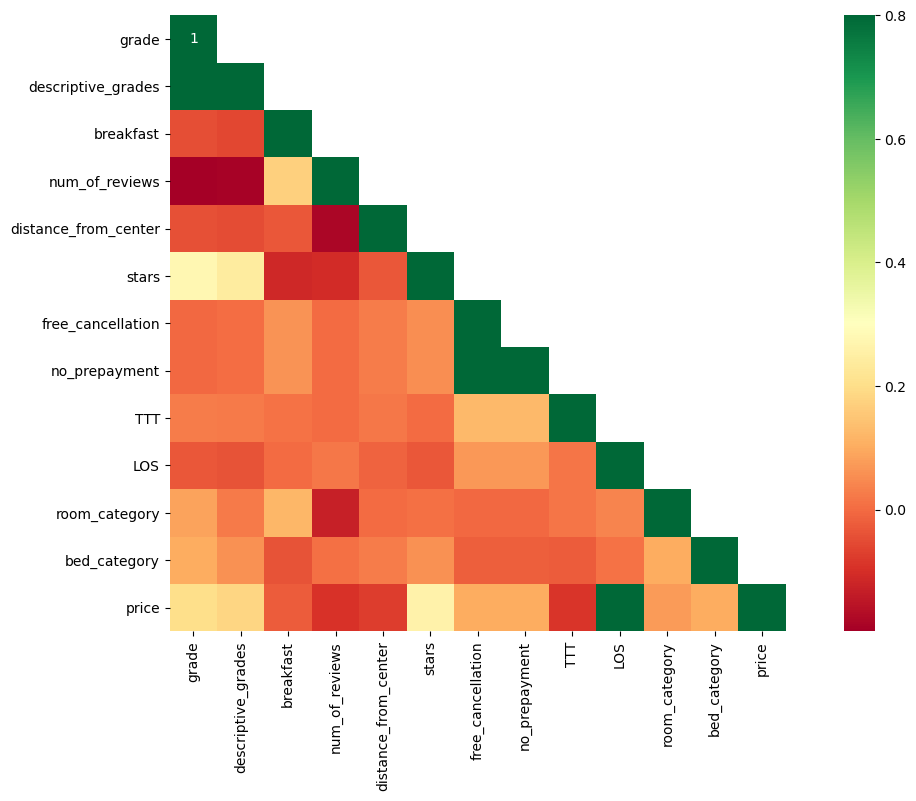

In [45]:
plt.figure(figsize=(15,8))
mask = np.array(data[['grade', 'descriptive_grades', 'breakfast','num_of_reviews', 'distance_from_center', 'stars', 'free_cancellation', 'no_prepayment', 'TTT', 'LOS','room_category', 'bed_category','price']].corr())
mask[np.tril_indices_from(mask)] = False
sns.heatmap(data[['grade', 'descriptive_grades', 'breakfast','num_of_reviews', 'distance_from_center', 'stars', 'free_cancellation', 'no_prepayment', 'TTT', 'LOS','room_category', 'bed_category','price']].corr(), annot=True, cmap='RdYlGn', mask=mask, vmax=0.8, square=True);

# Create the PairGrid

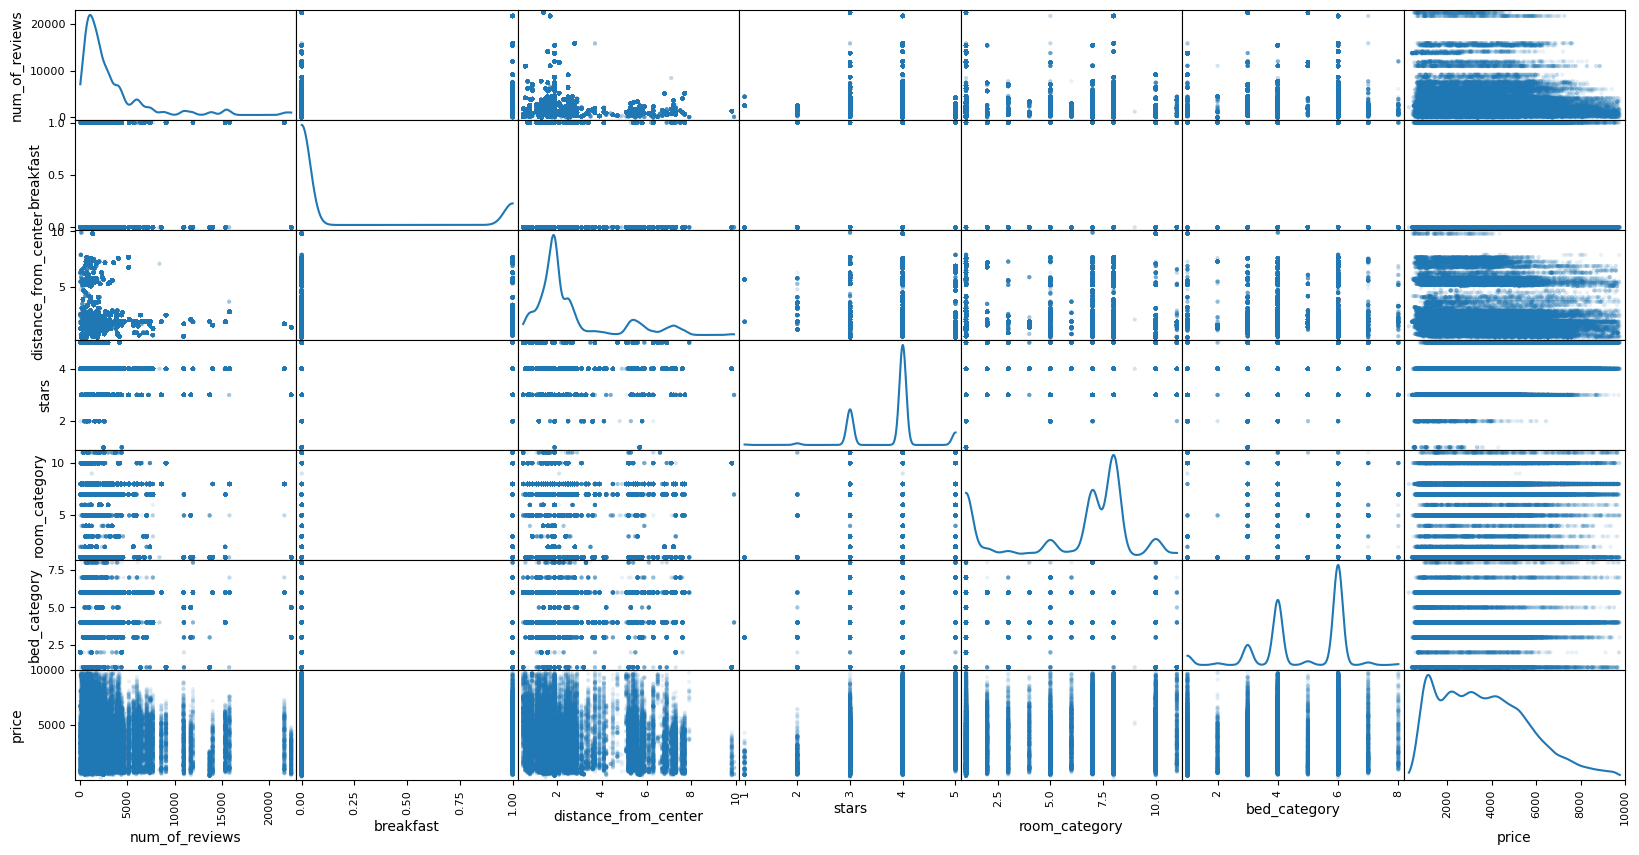

In [46]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[['num_of_reviews', 'breakfast', 'distance_from_center', 'stars', 'room_category', 'bed_category','price']], figsize=(20,10), alpha=0.1, diagonal='kde')
plt.show()

In [47]:
data.columns

Index(['name', 'grade', 'descriptive_grades', 'num_of_reviews', 'breakfast',
       'distance_from_center', 'stars', 'price', 'free_cancellation',
       'no_prepayment', 'checkin_date', 'checkout_date', 'TTT', 'LOS',
       'Snapshot Date', 'order', 'room_category', 'bed_category',
       'neighborhood_Battery Park, New York', 'neighborhood_Chelsea, New York',
       'neighborhood_Chinatown, New York',
       'neighborhood_East Harlem, New York',
       'neighborhood_East Village, New York',
       'neighborhood_Flatiron District, New York',
       'neighborhood_Gramercy, New York',
       'neighborhood_Greenwich Village, New York',
       'neighborhood_Harlem, New York',
       'neighborhood_Hell's Kitchen, New York',
       'neighborhood_Hudson Yards, New York',
       'neighborhood_Kips Bay, New York',
       'neighborhood_Little Italy, New York',
       'neighborhood_Lower East Side, New York',
       'neighborhood_Manhattan, New York',
       'neighborhood_Midtown East, New York'

## תובנות מהגרפים
קיים קשר חזק בין המחיר לבין LOS 

מול משתנה STARS קיים קשר חלש

לגבי כל יתר המשתנים - לא נמצא קשר אל מול המחיר

In [48]:
# שמירת הנתונים לקובץ CSV
data.to_csv('booking_data.csv', index=False)